# Milestone 2
Supervised learning.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import sklearn
import sklearn.preprocessing
import sklearn.metrics
import seaborn as sns; sns.set()

from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint

In [4]:
df = pd.read_csv('dengue_features_train.csv')
y = pd.read_csv('dengue_labels_train.csv')

## Filter data for group subset
Our group is working on dataset San Juan 1992-98

In [5]:
df['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [6]:
#criteria = (df['city'].values == 'sj', df['year'].values >= 1992, df['year'].values <= 1998)
#df = df[np.sum(criteria, axis=0, dtype=np.int8) == 3]
df = df[df['city'] == 'sj']
df = df[df['year'] >= 1992]
df = df[df['year'] <= 1998]

y = y[y['city'] == 'sj']
y = y[y['year'] >= 1992]
y = y[y['year'] <= 1998]

In [7]:
record_names = df[['city', 'year', 'weekofyear']]
df.drop(['week_start_date'], axis=1, inplace=True)
df.set_index(['city', 'year', 'weekofyear'], inplace=True)
all_features = df.columns
y.set_index(['city', 'year', 'weekofyear'], inplace=True)
df.shape, y.shape

((364, 20), (364, 1))

In [8]:
df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                           
sj   1992 1           0.125100  0.157867  0.185283  0.181367   
          2           0.100833  0.073575  0.138714  0.112786   
          3           0.222400  0.229900  0.198457  0.199414   
          4           0.122533  0.131050  0.188843  0.168871   
          5                NaN  0.048300  0.173671  0.191929   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1992 1                            NaN                    NaN   
          2                         200.85             297.912857   
          3                           3.12             297.338571   
          4                           0.00             297.091429   
          5                           0.00             297.420000   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1992 1                             NaN                          NaN   
          2                      298.121429                   294.457143   
          3                      297.485714                   294.467143   
          4                      297.335714                   293.021429   
          5                      297.550000                   292.718571   

                      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
city year weekofyear                                                         
sj   1992 1                                 NaN                        NaN   
          2                               300.4                      296.1   
          3                               300.2                      295.6   
          4                               299.5                      295.6   
          5                               299.3                      295.5   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1992 1                                       NaN   
          2                                     18.30   
          3                                     19.80   
          4                                      5.11   
          5                                      6.50   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1992 1                                            NaN   
          2                                      81.300000   
          3                                      84.117143   
          4                                      78.291429   
          5                                      75.220000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1992 1                                    NaN   
          2                                 200.85   
          3                                   3.12   
          4                                   0.00   
          5                                   0.00   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1992 1                                             NaN   
          2                                       15.878571   
          3                                       15.832857   
          4                                       14.482857   
          5                                       14.185714   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1992 1                         NaN                 NaN   
          2                    2.300000           25.657143   
          3                    1.857143           25.471429   
          4                    2.357143

In [9]:
df.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,281.000000,335.000000,348.000000,348.000000,358.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,358.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,0.074448,0.086447,0.173935,0.166330,33.584190,298.916779,299.033518,295.090823,301.168421,297.155125,36.301163,79.643431,33.584190,16.529600,2.352355,27.136090,6.915235,31.877839,22.640166,26.332964
std,0.081306,0.066450,0.049938,0.050769,41.398772,1.122997,1.106125,1.493193,1.143217,1.194633,42.769553,3.337513,41.398772,1.489095,0.443310,1.332723,0.833416,1.593252,1.436071,30.184534
min,-0.290200,-0.130950,0.051471,0.028650,0.000000,296.425714,296.635714,290.378571,298.200000,293.500000,0.000000,67.364286,0.000000,12.331429,1.357143,23.700000,4.585714,27.800000,18.900000,0.000000
25%,0.033900,0.049400,0.142425,0.132032,0.000000,297.882857,298.071429,293.834286,300.300000,296.200000,13.690000,77.505714,0.000000,15.235714,2.042857,26.028571,6.357143,31.100000,21.700000,6.700000
50%,0.074200,0.083667,0.174907,0.168393,19.655000,299.131429,299.221429,295.435714,301.300000,297.500000,24.300000,79.775714,19.655000,16.822857,2.300000,27.314286,6.900000,32.200000,22.800000,16.900000
75%,0.114600,0.125325,0.204823,0.202836,50.292500,299.867143,299.957143,296.288571,302.100000,298.100000,45.200000,82.212857,50.292500,17.712857,2.571429,28.214286,7.442857,32.800000,23.900000,35.600000
max,0.363300,0.290900,0.349314,0.312600,243.550000,301.218571,301.350000,297.467143,303.900000,299.300000,570.500000,87.301429,243.550000,19.044286,4.000000,30.071429,9.914286,35.600000,25.600000,305.900000


# Preprocessing

## Fill NaN

In [10]:
df.isna().sum()
# ffill: propagate last valid observation forward to next valid backfill
# @ Check other methods
df.fillna(method="bfill", inplace=True)
df.isna().sum()

ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int64

## PCA
Normalize the data and apply find best principal components.

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
#scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(df)

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca.shape

(364, 20)

## Prepare working set

In [16]:
#features = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg']
X = pd.DataFrame(X, index=df.index, columns=all_features)

# 1. Baseline

### Helper functions

In [151]:
def split_to_train(X, y, test_size=0.1):
      return train_test_split(pd.concat([X, y], axis=1), test_size=test_size)
    
def get_predictions(regressor, X):
    return regressor.predict(X)

def get_mae(regressor, X, y):
    y_pred = get_predictions(regressor, X)
    return mean_absolute_error(y_pred, y)

def fit_regressor(regressor, X, y):
    train, test = split_to_train(X, y)
    regressor.fit(X=train.drop(['total_cases'], axis=1), y=train['total_cases'])
    
    return get_mae(regressor, test.drop(['total_cases'], axis=1), test['total_cases'])

def generate_visualization(regressor, X, y):
    y_pred = regressor.predict(X)
    mae = mean_absolute_error(y, y_pred)

    plt.plot(np.arange(len(X)), y, c='r', label='data')
    plt.plot(np.arange(len(X)), y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    #plt.title("RandomForests GridSearchCV (MAE = %6.2f')" % ( mae))

    plt.show()
    return mae

def get_fold_accuracy(regressor, X, y, n_splits=10):
    fold_accuracy = []
    cv = KFold(n_splits, shuffle=False)
    for train_fold, test_fold in cv.split(X):
        X_train = X.iloc[train_fold]
        X_test = X.iloc[test_fold]
        y_train = y.iloc[train_fold]
        y_test = y.iloc[test_fold]

        regressor.fit(X=X_train, y=y_train.values.ravel())
        fold_accuracy.append(get_mae(regressor, X_test, y_test))
    return fold_accuracy

def get_accuracy(regressor, X, y, n_splits=10):
    fold_accuracy = get_fold_accuracy(regressor, X, y, n_splits)
    return sum(fold_accuracy)/len(fold_accuracy)

def generate_plot(X, y, regressor, param_name, to=30, n_split=10):
    mae = []
    for i in range(2, to):
        regressor.set_params(**{param_name:i})
        fold_accuracy = get_fold_accuracy(regressor, X, y, n_split)
        mae.append(sum(fold_accuracy)/len(fold_accuracy))

    label = type(regressor).__name__

    if type(regressor).__name__ == 'KNeighborsRegressor':
        label = regressor.get_params()['weights']
    elif type(regressor).__name__ == 'RandomForestRegressor':
        params = regressor.get_params()
        n_estimators = params['n_estimators']
        max_depth = params[param_name]
        label = f'n_estimators={n_estimators}'

    plt.plot(range(1, len(mae)+1), mae, marker='o', 
           label=label)
    print ('Min Value: {} ({})'.format(min(mae), np.argmin(mae) + 1))
    plt.ylabel('MAE')
    plt.legend()

def save_results(y_pred, name):
    res = np.rint(y_pred) # round
    res = res.astype(int) # cast to int
    aux = pd.DataFrame(res, index=pd.MultiIndex.from_arrays(record_names.values.T), columns=['predicition'])
    aux.to_csv(name)
    return name

## 1.1 KNN

### 1.1.1 Mean absolute error

Min Value: 37.44903846153847 (5)
Min Value: 37.483090675719424 (7)


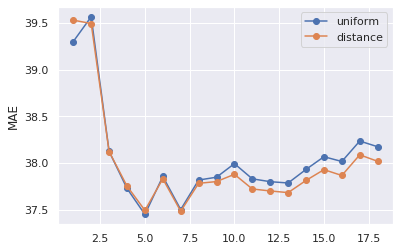

In [46]:
for weights in ['uniform', 'distance']:
    knn = neighbors.KNeighborsRegressor(weights=weights)
    generate_plot(X, y, knn, 'n_neighbors', 20, 30)
plt.show()  

### 1.1.2 Predictions

#### Model creation

In [92]:
result_files = []

In [105]:
n_neighbors = 5
weights = 'uniform'
knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights) 

print('MAE: ', fit_regressor(knn, X, y))

MAE:  29.097297297297295


In [106]:
y_pred = get_predictions(knn, X)
y_pred.shape

(364,)

### 1.1.3 Save results

In [107]:
file_name = save_results(y_pred, 'knn_results.csv')
result_files.append(file_name)


### 1.1.4 Visualisation

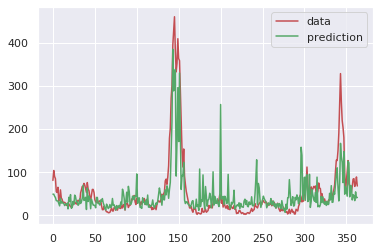

25.25824175824176

In [108]:
generate_visualization(knn, X, y)

## 1.2 Decision Tree

### 1.2.1 Mean absolute error

Min Value: 31.259754339726964 (2)


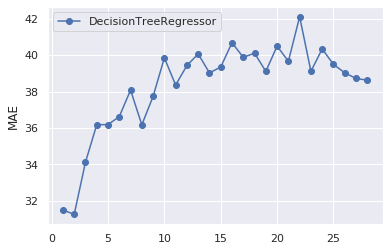

In [109]:
dt = DecisionTreeRegressor()
generate_plot(X, y, dt, 'max_depth', 30, 10)
plt.show()

### 1.2.2 Predictions

In [111]:
dt = DecisionTreeRegressor(max_depth=3)
fit_regressor(dt, X, y)

25.50996940336563

In [113]:
y_pred = get_predictions(dt, X)

### 1.2.3 Save results

In [114]:
file_name = save_results(y_pred, 'DecisionTree_results')
result_files.append(file_name)

### 1.2.4 Visualisation

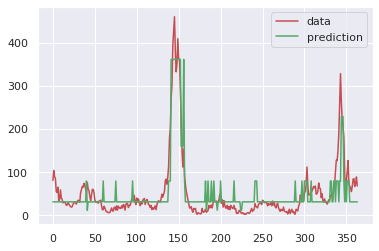

22.468364261524638

In [115]:
generate_visualization(dt, X, y)

## 1.3 Random forest

### 1.3.1 Mean absolute error

Min Value: 35.15007507507507 (3)
Min Value: 35.28732482482483 (3)
Min Value: 34.400731981981984 (3)
Min Value: 34.66747747747748 (1)
Min Value: 35.20391641641642 (1)
Min Value: 34.858649721149725 (1)


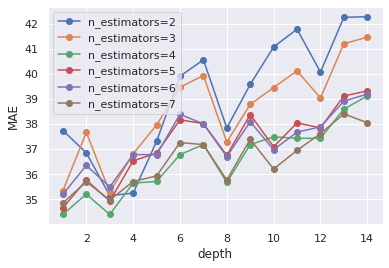

In [119]:
max_estimators = 8
max_max_depth = 16
for n in range(2, max_estimators):
    rf = RandomForestRegressor(n_estimators=n, criterion='mae', random_state=0)
    generate_plot(X, y, rf, 'max_depth', max_max_depth, 10)
plt.xlabel('depth')
plt.show()

### 1.3.2 Predictions

In [122]:
rf = RandomForestRegressor(n_estimators=4, max_depth=3, criterion='mae', random_state=0)
fit_regressor(rf, X, y)

27.16891891891892

In [123]:
y_pred = get_predictions(rf, X)

### 1.3.3 Save results

In [124]:
file_name = save_results(y_pred, 'RandomForest_results')
result_files.append(file_name)

### 1.3.4 Visualisation

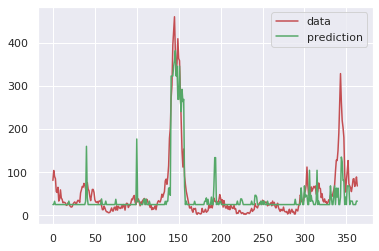

23.663804945054945

In [125]:
generate_visualization(rf, X, y)

# 2. Optimization

## Helper functions

In [133]:
def report(results, n_top=3): 
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

## 2.1 Boosting

In [126]:
regressor_names = ['KNN', 'Decision tree', 'Random Forest', 'Ada Boost', 'GradientBoosting']
regressors = [KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights),
              DecisionTreeRegressor(max_depth=6),
              RandomForestRegressor(n_estimators=4, max_depth=3,
                                    criterion='mae',random_state=0),
              AdaBoostRegressor(RandomForestRegressor(n_estimators=4, 
                                max_depth=3, criterion='mae', random_state=0)),
              GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                   max_depth=4, random_state=0, loss='ls')]

In [127]:
for i, reg in enumerate(regressors):
    print(f'{regressor_names[i]}:\n\tMAE:{get_accuracy(reg, X, y, 12)}')

KNN:
	MAE:42.23879928315412
Decision tree:
	MAE:42.19724065518248
Random Forest:
	MAE:39.19174507168458
Ada Boost:
	MAE:44.98760080645161
GradientBoosting:
	MAE:40.775016838770675


In [128]:
regressors_df = pd.DataFrame({regressor_names[1]:regressors[1].feature_importances_, 
              regressor_names[2]:regressors[2].feature_importances_, 
              regressor_names[3]:regressors[3].feature_importances_,
              regressor_names[4]:regressors[4].feature_importances_, },
              index=all_features)

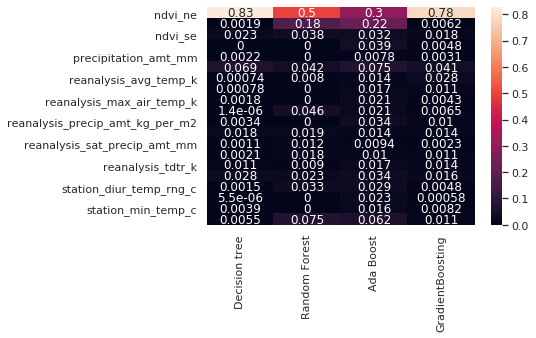

In [129]:
sns.heatmap(regressors_df, annot=True)

## 2.2 Grid Search

### 2.2.1 Setting

In [145]:
train, test = split_to_train(X, y, 0.2)
X_train = train.drop(['total_cases'], axis=1)
y_train = train['total_cases']
X_test = test.drop(['total_cases'], axis=1)
y_test = test['total_cases']

In [146]:
param_dist = {"n_estimators": [32, 64, 128], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8, 4, 2], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16], # Minimum number of samples required at each leaf node
              "bootstrap": [True, False] # Method of selecting samples for training each tree
            }

In [147]:
rf = RandomForestRegressor()
grid_regres = GridSearchCV(estimator=rf, param_grid=param_dist, cv=5)

grid_regres.fit(X_test, y_test.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [8, 4, 2],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [8, 12, 16],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [32, 64, 128]})

### 2.2.2 Results

In [148]:
report(grid_regres.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: -0.488 (std: 0.565)
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 64}

Model with rank: 2
Mean validation score: -0.659 (std: 0.858)
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 32}

Model with rank: 3
Mean validation score: -0.717 (std: 0.906)
Parameters: {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 128}

Model with rank: 4
Mean validation score: -0.721 (std: 0.966)
Parameters: {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 32}

Model with rank: 5
Mean validation score: -0.722 (std: 0.884)
Parameters: {'bootstrap': False, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_es

In [149]:
grid_regres.best_params_

{'bootstrap': False,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 64}

In [152]:
get_mae(grid_regres.best_estimator_, X, y)

32.28477274809478

### 2.2.3 Visualisation

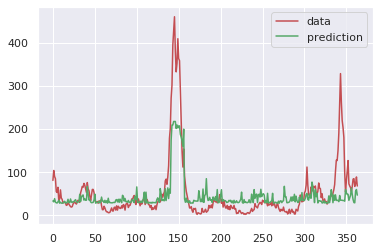

27.73752843913629

In [137]:
generate_visualization(grid_regres.best_estimator_, X, y)

## 2.3 Randomized Search

### 2.3.1 Setting

In [138]:
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [16, 12, 8, 4, 2, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["mse", "mae"]}

In [139]:
rnd_regres = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                               n_iter=100, cv=5, random_state=0, n_jobs=-1)
rnd_regres.fit(X_test, y_test.values.ravel())

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [16, 12, 8, 4, 2, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7568663220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7568115ac0>,
                                        'n_estimators': [4, 8, 16, 32, 64,
                                                         128]},
                   random_state=0)

### 2.3.2 Results

In [140]:
report(rnd_regres.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.384 (std: 0.317)
Parameters: {'bootstrap': False, 'criterion': 'mae', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 24, 'n_estimators': 4}

Model with rank: 2
Mean validation score: 0.261 (std: 0.260)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 4}

Model with rank: 3
Mean validation score: 0.198 (std: 0.223)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 38, 'n_estimators': 16}

Model with rank: 4
Mean validation score: 0.179 (std: 0.763)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 30, 'n_estimators': 64}

Model with rank: 5
Mean validation score: 0.140 (std: 0.528)
Parameters: {'bootstrap': True, 'criterion': 'm

In [141]:
rnd_regres.best_params_

{'bootstrap': False,
 'criterion': 'mae',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 24,
 'n_estimators': 4}

In [142]:
get_mae(rnd_regres.best_estimator_, X, y)

43.496987612612614

### 2.3.3 Visualisation

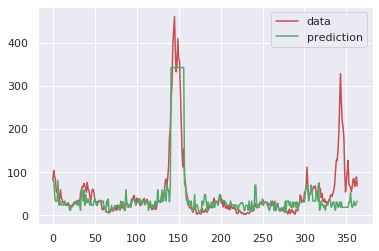

21.65521978021978

In [143]:
generate_visualization(rnd_regres.best_estimator_, X, y)